In [65]:
import numpy as np

###Three dimention data

####MSE function

In [66]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

#### Fit fuction

In [67]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 200 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

#### Plot tsne function

In [68]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 1], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

####Linear model

In [69]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

#### Non-Linear model generation


3 layers neural network using relu nonlinearity

In [70]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

class Model:
  def __init__(self, input_dim, num_hidden, ouput_dim):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.relu2 = Relu()
    self.linear2 = Linear(num_hidden, ouput_dim)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    r2 = self.relu2(r1)
    l2 = self.linear2(r2)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear2_gradient)
    relu1_gradient = self.relu1.backward(relu2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

####Three dimention non-linear input generation

In [71]:
n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
bias_true = np.array([0.5, 0.1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


####Initialize nonlinear and loss for three dimention data

3-d input and 2-d output with 2 hidden layers, 10 neurons for hidden layers

In [72]:
loss = MSE()
nonlinear = Model(3, 20, 2)
y_pred = nonlinear(x)
print(x.shape, weights_true.shape, y_true.shape, y_pred.shape)
print(loss(y_pred, y_true))

(200, 3) (3, 2) (200, 2) (200, 2)
5.007312203605959


####Train three dimention data

In [73]:
fit(x, y_true, model=nonlinear, loss=loss, lr=0.1, num_epochs=4000)

y_pred = nonlinear(x)

Epoch 0, loss 5.007312203605959
Epoch 200, loss 0.03601407685130306
Epoch 400, loss 0.030063164800712062
Epoch 600, loss 0.025724984488762526
Epoch 800, loss 0.020953498538495537
Epoch 1000, loss 0.017999321103808863
Epoch 1200, loss 0.015636350074245717
Epoch 1400, loss 0.014170519524278962
Epoch 1600, loss 0.01318029300215702
Epoch 1800, loss 0.012348683027105211
Epoch 2000, loss 0.01135549207240686
Epoch 2200, loss 0.010790282335655675
Epoch 2400, loss 0.010338096326306077
Epoch 2600, loss 0.00998716351615197
Epoch 2800, loss 0.010694182322726488
Epoch 3000, loss 0.013741023950155981
Epoch 3200, loss 0.012787916915283271
Epoch 3400, loss 0.013184764127215174
Epoch 3600, loss 0.013742595204473773
Epoch 3800, loss 0.012424517208134502


####Plot the output and the real data using tsne

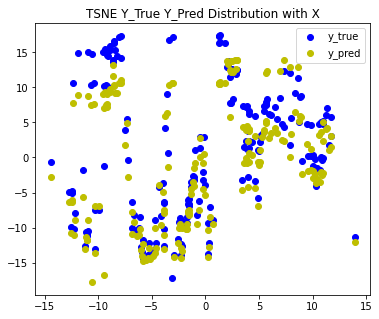

In [74]:
plot_distribution(x, y_true, y_pred)

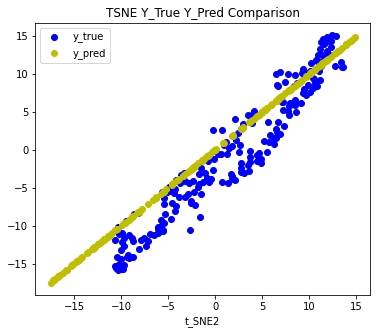

In [75]:
plot_comparison(y_true, y_pred)

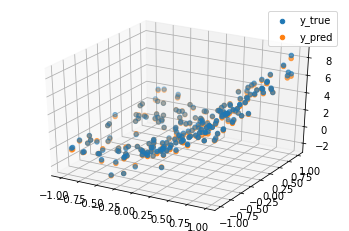

In [76]:
plot_3d(x, y_true[:, 0], y_pred=y_pred[:, 0])